In [1]:
# Imports for data handling and plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cv2

# Scikit-learn for metrics and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.preprocessing import LabelEncoder, label_binarize

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Kaggle dataset downloader
import kagglehub

# Setup device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Download the dataset using KaggleHub
path = kagglehub.dataset_download("dhruvildave/english-handwritten-characters-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/english-handwritten-characters-dataset


In [4]:
# Define the path to the image data
data_dir = '/kaggle/input/english-handwritten-characters-dataset'

X, y = [], []
# Loop through all files in the directory
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".png"):
            path = os.path.join(root, file)
            # Read image in grayscale, resize to 28x28
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (28, 28))
            # Flatten the image to a 1D vector
            X.append(img.flatten())

            # Extract the label from the filename (e.g., 'img001-001.png' -> '001')
            label = file.split("-")[0]
            label = label.replace('img', '')
            y.append(label)

# Convert lists to NumPy arrays and normalize pixel values to [0, 1]
X = np.array(X) / 255.0
y = np.array(y)

# Encode string labels to integer indices
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Data loading and preprocessing complete.")
print("Shape of X:", X.shape)
print("Shape of y_encoded:", y_encoded.shape)
print("Available classes:", le.classes_)

Data loading and preprocessing complete.
Shape of X: (3410, 784)
Shape of y_encoded: (3410,)
Available classes: ['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '020' '021' '022' '023' '024'
 '025' '026' '027' '028' '029' '030' '031' '032' '033' '034' '035' '036'
 '037' '038' '039' '040' '041' '042' '043' '044' '045' '046' '047' '048'
 '049' '050' '051' '052' '053' '054' '055' '056' '057' '058' '059' '060'
 '061' '062']


In [5]:
# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Prepare data for PLA (Binary Classification) ---
# Choose the first class as the positive class for our binary problem
chosen_class_index = 0
chosen_class_name = le.classes_[chosen_class_index]
print(f"Chosen class for binary classification (PLA): '{chosen_class_name}'")

# Create binary labels: 1 if the sample is the chosen class, 0 otherwise
y_train_binary = np.where(y_train == chosen_class_index, 1, 0)
y_test_binary = np.where(y_test == chosen_class_index, 1, 0)

print("Train class distribution (0 vs All):", np.bincount(y_train_binary))
print("Test class distribution (0 vs All):", np.bincount(y_test_binary))

# Convert all data to PyTorch tensors and move to the selected device
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_binary_t = torch.tensor(y_train_binary, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_binary_t = torch.tensor(y_test_binary, dtype=torch.float32).to(device)

Chosen class for binary classification (PLA): '001'
Train class distribution (0 vs All): [2684   44]
Test class distribution (0 vs All): [671  11]


In [6]:
# Initialize weights and bias for the perceptron
input_features = X_train_t.shape[1]
weights = torch.zeros(input_features, device=device)
bias = torch.tensor(0.0, device=device)

# Hyperparameters
learning_rate = 0.01
epochs = 5

# Step activation function
def step(z):
    return torch.where(z >= 0, 1.0, 0.0)

# PLA Training Loop
for epoch in range(epochs):
    for i in range(len(X_train_t)):
        xi = X_train_t[i]
        target = y_train_binary_t[i]

        # Calculate prediction
        z = torch.dot(xi, weights) + bias
        y_pred = step(z)

        # Update weights and bias based on error
        update = learning_rate * (target - y_pred)
        weights += update * xi
        bias += update

print("PLA training complete.")

# Prediction function for PLA
def predict_pla(X):
    z = torch.matmul(X, weights) + bias
    return step(z)

# Evaluate PLA on the test set
y_pred_pla_t = predict_pla(X_test_t)
y_pred_pla = y_pred_pla_t.cpu().numpy() # Convert to NumPy for sklearn metrics

PLA training complete.


--- PLA Metrics ---
Accuracy: 0.9839
Precision (Macro): 0.4919
Recall (Macro): 0.5000
F1-Score (Macro): 0.4959


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


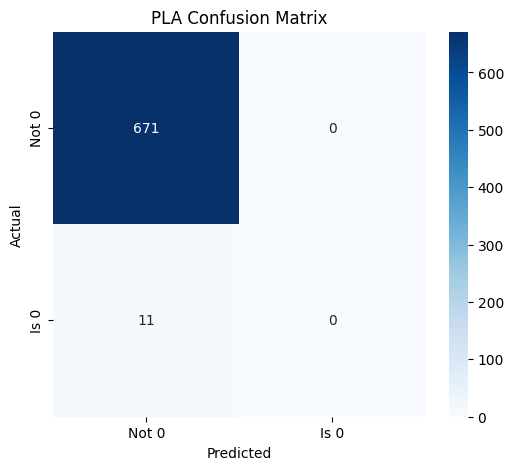

In [7]:
# PLA Metrics
print("--- PLA Metrics ---")
print(f"Accuracy: {accuracy_score(y_test_binary, y_pred_pla):.4f}")
print(f"Precision (Macro): {precision_score(y_test_binary, y_pred_pla, average='macro'):.4f}")
print(f"Recall (Macro): {recall_score(y_test_binary, y_pred_pla, average='macro'):.4f}")
print(f"F1-Score (Macro): {f1_score(y_test_binary, y_pred_pla, average='macro'):.4f}")

# Plot PLA Confusion Matrix
cm_pla = confusion_matrix(y_test_binary, y_pred_pla)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_pla, annot=True, fmt='d', cmap='Blues', xticklabels=['Not 0', 'Is 0'], yticklabels=['Not 0', 'Is 0'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('PLA Confusion Matrix')
plt.show()

In [8]:
# --- MLP Implementation ---

# Convert multiclass labels to tensors for MLP training
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

num_classes = len(le.classes_)
input_size = X_train.shape[1]

# Define the MLP architecture
mlp = nn.Sequential(
    nn.Linear(input_size, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
).to(device)

print(mlp)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

Sequential(
  (0): Linear(in_features=784, out_features=1024, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.3, inplace=False)
  (11): Linear(in_features=256, out_features=62, bias=True)
)


In [9]:
# Create DataLoader for batching
batch_size = 64
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop with history tracking
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
epochs = 30

for epoch in range(epochs):
    mlp.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training metrics for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)

    # Validation loop
    mlp.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mlp(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate validation metrics for the epoch
    epoch_val_loss = val_loss / len(test_loader)
    epoch_val_acc = correct_val / total_val
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_acc)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

print("MLP training finished.")

Epoch [1/30], Loss: 3.7729, Acc: 0.1045, Val Loss: 3.6594, Val Acc: 0.0938
Epoch [2/30], Loss: 2.8004, Acc: 0.2812, Val Loss: 3.5693, Val Acc: 0.1642
Epoch [3/30], Loss: 2.3272, Acc: 0.3849, Val Loss: 3.0855, Val Acc: 0.2405
Epoch [4/30], Loss: 2.0113, Acc: 0.4586, Val Loss: 3.6273, Val Acc: 0.2390
Epoch [5/30], Loss: 1.7644, Acc: 0.5187, Val Loss: 2.5295, Val Acc: 0.3446
Epoch [6/30], Loss: 1.5887, Acc: 0.5539, Val Loss: 2.8122, Val Acc: 0.3255
Epoch [7/30], Loss: 1.4045, Acc: 0.6026, Val Loss: 2.5824, Val Acc: 0.3548
Epoch [8/30], Loss: 1.2978, Acc: 0.6210, Val Loss: 2.5170, Val Acc: 0.3827
Epoch [9/30], Loss: 1.2009, Acc: 0.6499, Val Loss: 2.8607, Val Acc: 0.3446
Epoch [10/30], Loss: 1.0934, Acc: 0.6767, Val Loss: 2.3615, Val Acc: 0.4267
Epoch [11/30], Loss: 0.9714, Acc: 0.7060, Val Loss: 3.2040, Val Acc: 0.3065
Epoch [12/30], Loss: 0.9124, Acc: 0.7207, Val Loss: 3.0768, Val Acc: 0.3328
Epoch [13/30], Loss: 0.8709, Acc: 0.7262, Val Loss: 2.7304, Val Acc: 0.3915
Epoch [14/30], Loss: 

--- MLP Metrics ---
Accuracy: 0.4076
Precision (Macro): 0.4832
Recall (Macro): 0.4076
F1-Score (Macro): 0.4028

MLP Classification Report:
              precision    recall  f1-score   support

         001       0.14      0.09      0.11        11
         002       0.27      0.36      0.31        11
         003       0.60      0.27      0.38        11
         004       0.33      0.18      0.24        11
         005       0.20      0.18      0.19        11
         006       0.50      0.27      0.35        11
         007       0.21      0.36      0.27        11
         008       0.33      0.45      0.38        11
         009       0.60      0.27      0.38        11
         010       0.17      0.09      0.12        11
         011       0.45      0.45      0.45        11
         012       0.38      0.55      0.44        11
         013       0.75      0.27      0.40        11
         014       0.55      0.55      0.55        11
         015       0.62      0.45      0.53       

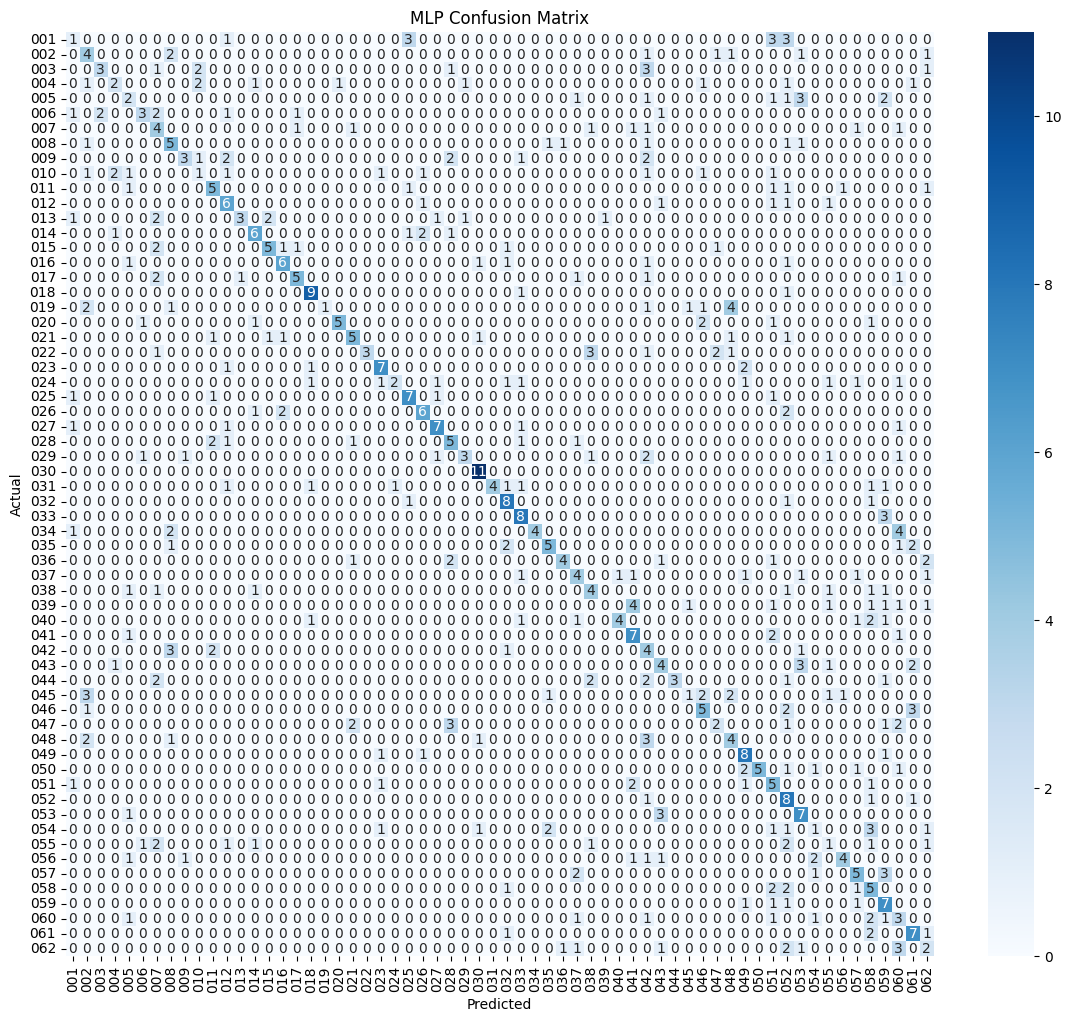

In [10]:
# --- MLP Evaluation ---
mlp.eval()
y_pred_list = []
y_score_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = mlp(inputs)
        # Apply softmax to get probabilities for ROC curve
        scores = nn.functional.softmax(outputs, dim=1)
        y_score_list.append(scores.cpu().numpy())
        # Get class predictions
        _, predicted = torch.max(outputs.data, 1)
        y_pred_list.extend(predicted.cpu().numpy())

y_pred_mlp = np.array(y_pred_list)
y_score_mlp = np.concatenate(y_score_list, axis=0)

# Print MLP Metrics
print("--- MLP Metrics ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(f"Precision (Macro): {precision_score(y_test, y_pred_mlp, average='macro', zero_division=0):.4f}")
print(f"Recall (Macro): {recall_score(y_test, y_pred_mlp, average='macro', zero_division=0):.4f}")
print(f"F1-Score (Macro): {f1_score(y_test, y_pred_mlp, average='macro', zero_division=0):.4f}\n")

# Print Classification Report
print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_, zero_division=0))

# Plot MLP Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(14, 12))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('MLP Confusion Matrix')
plt.show()

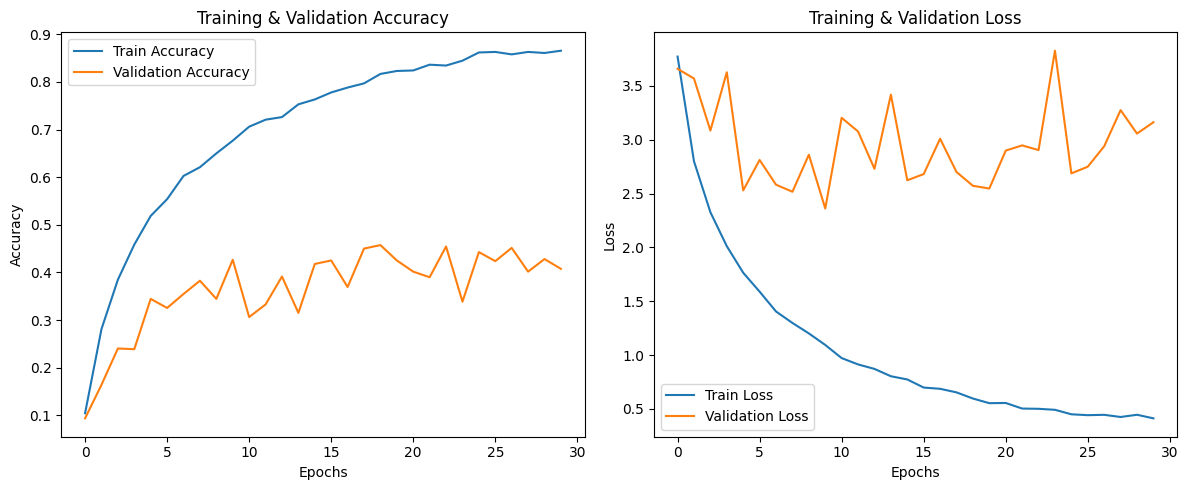

In [11]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label="Train Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label="Train Loss")
plt.plot(history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

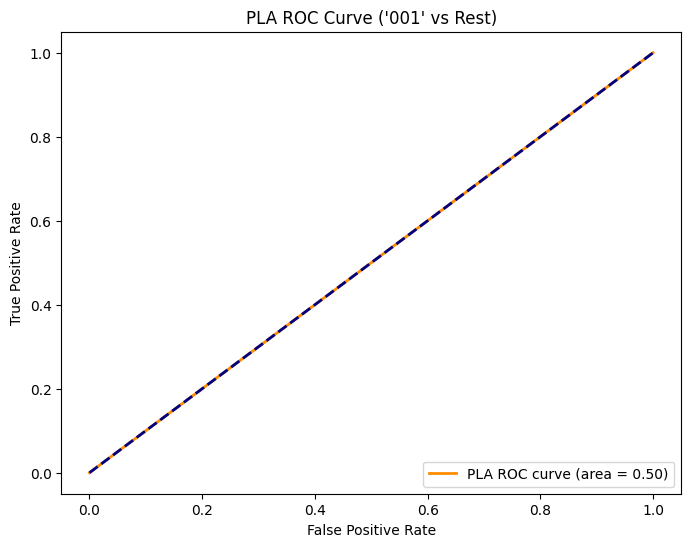

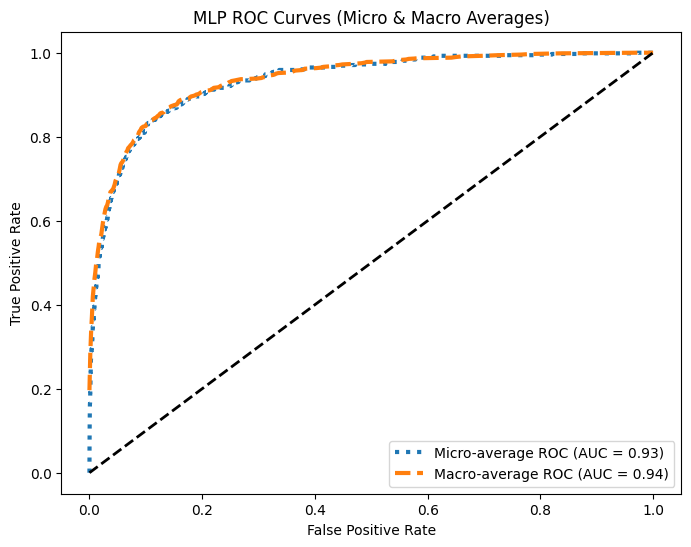

In [12]:
# --- ROC Curve Plotting ---

# 1. PLA ROC Curve
fpr_pla, tpr_pla, _ = roc_curve(y_test_binary, y_pred_pla)
roc_auc_pla = auc(fpr_pla, tpr_pla)

plt.figure(figsize=(8, 6))
plt.plot(fpr_pla, tpr_pla, color='darkorange', lw=2, label=f'PLA ROC curve (area = {roc_auc_pla:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"PLA ROC Curve ('{chosen_class_name}' vs Rest)")
plt.legend(loc="lower right")
plt.show()


# 2. MLP ROC Curve (Micro and Macro)
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score_mlp.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_score_mlp[:, i])[0] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_mlp[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= num_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, linestyle=':', lw=3, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})')
plt.plot(all_fpr, mean_tpr, linestyle='--', lw=3, label=f'Macro-average ROC (AUC = {roc_auc_macro:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curves (Micro & Macro Averages)')
plt.legend(loc='lower right')
plt.show()

# Experiment 5: Perceptron vs Multilayer Perceptron (A/B Experiment)

## Objective
To implement and compare:
- **Model A**: Single-Layer Perceptron Learning Algorithm (PLA).
- **Model B**: Multilayer Perceptron (MLP) with hidden layers and nonlinear activations.

We aim to understand the strengths and weaknesses of simple linear models vs deep neural networks.

## Dataset
- **English Handwritten Characters Dataset**
- ~3,410 images across 62 classes (digits `0–9`, uppercase `A–Z`, lowercase `a–z`).
- Each image is resized to 28×28, flattened, and normalized.

## Methodology
1. **Preprocessing**: Resize, flatten, normalize images, encode labels.
2. **PLA Implementation**:
   - Step activation function.
   - Binary classification (character "0" vs "not-0").
   - Weight update using perceptron learning rule.
3. **MLP Implementation**:
   - Input → Dense(1024, ReLU) → BN/Dropout → Dense(512, ReLU) → BN/Dropout → Dense(256, ReLU) → Dropout → Output(62).
   - Trained with Adam optimizer and Cross-Entropy loss.
   - Evaluated on the full multi-class dataset.
4. **Evaluation Metrics**:
   - Accuracy, Precision, Recall, F1-score.
   - Confusion Matrices.
   - ROC Curves (PLA binary, MLP micro/macro).
   - Training vs Validation loss/accuracy curves.

## Key Insight
- **PLA**: A simple linear classifier that struggles with complex, non-linearly separable data like handwritten characters, resulting in lower performance.
- **MLP**: Its deep architecture with non-linear activations allows it to learn complex features and decision boundaries, achieving significantly higher accuracy on this multiclass classification task.
- This comparison highlights the power of neural networks for complex pattern recognition tasks where linear models are insufficient.